# RNN model for HAR
## Consists of two GRU layer With a Dense layer at the end and output layer
### Using fit generator because the dataset is large

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, GRU, Bidirectional, BatchNormalization, Dropout, CuDNNGRU
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils.io_utils import HDF5Matrix
from keras.callbacks import History 
history = History()

model = Sequential()
#define first two bidirectional lstm/gru layer with around 300 neurons
model.add(Bidirectional(CuDNNGRU(600, return_sequences=True), input_shape=(300, 120)))
model.add(Bidirectional(CuDNNGRU(600)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

#define a fully connected hidden layer with about 300 neurons
model.add(Dense(600))
model.add(Activation('relu'))

#define a output layer with 3 neurons
model.add(Dense(60))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01, decay=0.9),  metrics=['accuracy'])

C:\Users\dilra\Anaconda3\envs\skeleton\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 300, 1200)         2599200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1200)              6487200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1200)              4800      
_________________________________________________________________
activation_1 (Activation)    (None, 1200)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               720600    
_________________________________________________________________
activation_2 (Activation)    (None, 600)               0         
__________

In [2]:
# Generator section
def data_generator(totalsamples, batchsize = 100):

    number_of_batches = totalsamples/batchsize
    start = 0
    while 1:
        X = HDF5Matrix('E:/nturgbd_skeletons/traindataset.h5', 'traindata', start, start + batchsize)
        y = HDF5Matrix('E:/nturgbd_skeletons/traindataset.h5', 'trainlabel', start, start + batchsize)
        start = start + batchsize
        yield (X,y)
        
        #restart counter to yeild data in the next epoch as well
        if start > number_of_batches:
            start = 0
            
#loading all the test data from the h5 file
vtrain = HDF5Matrix('E:/nturgbd_skeletons/dataset.h5', 'testdata', 0, 5000)
vtarget = HDF5Matrix('E:/nturgbd_skeletons/dataset.h5', 'testlabel', 0, 5000)

# Early stopping for no progress in validation in loss
# es = EarlyStopping(monitor='val_acc', min_delta=0.1, patience=4, verbose=1, mode='auto')

# watch the model graphically
tb = TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=32, write_graph=True, write_images=True)

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath='E:/nturgbd_skeletons/lr0.01bs50weights.hdf5', verbose=2, save_best_only=True)

In [3]:
getdata = data_generator(50000, 40)
model.fit_generator(generator = getdata, steps_per_epoch=1250, epochs=10, verbose=2, validation_data=(vtrain, vtarget), shuffle=True, callbacks=[checkpointer,tb,history])

Epoch 1/10
 - 1260s - loss: 2.9410 - acc: 0.2120 - val_loss: 3.9641 - val_acc: 0.1332

Epoch 00001: val_loss improved from inf to 3.96406, saving model to E:/nturgbd_skeletons/lr0.01bs50weights.hdf5
Epoch 2/10
 - 1220s - loss: 2.5253 - acc: 0.2982 - val_loss: 4.1489 - val_acc: 0.1396

Epoch 00002: val_loss did not improve from 3.96406
Epoch 3/10
 - 1291s - loss: 2.3758 - acc: 0.3301 - val_loss: 4.1981 - val_acc: 0.1446

Epoch 00003: val_loss did not improve from 3.96406
Epoch 4/10
 - 1286s - loss: 2.2726 - acc: 0.3533 - val_loss: 4.2253 - val_acc: 0.1472

Epoch 00004: val_loss did not improve from 3.96406
Epoch 5/10
 - 1283s - loss: 2.1961 - acc: 0.3715 - val_loss: 4.2652 - val_acc: 0.1502

Epoch 00005: val_loss did not improve from 3.96406
Epoch 6/10
 - 1272s - loss: 2.1342 - acc: 0.3849 - val_loss: 4.2784 - val_acc: 0.1524

Epoch 00006: val_loss did not improve from 3.96406
Epoch 7/10
 - 1297s - loss: 2.0841 - acc: 0.3983 - val_loss: 4.2686 - val_acc: 0.1550

Epoch 00007: val_loss di

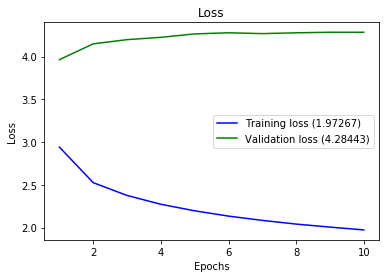

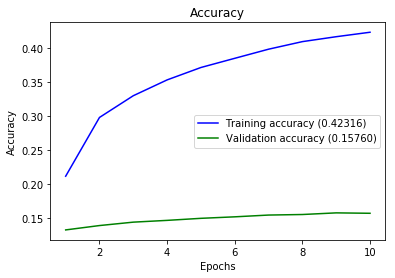

In [6]:
#plotting the graph
# import os
# os.environ["PATH"] += os.pathsep + 'C:/release/bin/'
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')
# history.history.keys()
# model.save("E:/nturgbd_skeletons/bs40do0.3lr0.01e10acc42.32valacc15.76model.h5")
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plot_history(history)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
# from sklearn import datasets
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# seed = 1000

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

Accuracy : 0.194

Classification Report
             precision    recall  f1-score   support

          0    1.00000   0.04762   0.09091        21
          1    0.00000   0.00000   0.00000        14
          2    0.07692   0.15385   0.10256        13
          3    0.31250   0.23810   0.27027        21
          4    0.21053   0.30769   0.25000        13
          5    0.59091   0.46429   0.52000        28
          6    0.00000   0.00000   0.00000        17
          7    0.29730   0.68750   0.41509        16
          8    0.43478   0.55556   0.48780        18
          9    0.03846   0.06250   0.04762        16
         10    0.00000   0.00000   0.00000        12
         11    0.00000   0.00000   0.00000        20
         12    0.33333   0.11765   0.17391        17
         13    0.35714   0.33333   0.34483        15
         14    0.21429   0.27273   0.24000        22
         15    0.26667   0.47059   0.34043        17
         16    0.18182   0.20000   0.19048        20
     

C:\Users\dilra\Anaconda3\envs\skeleton\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


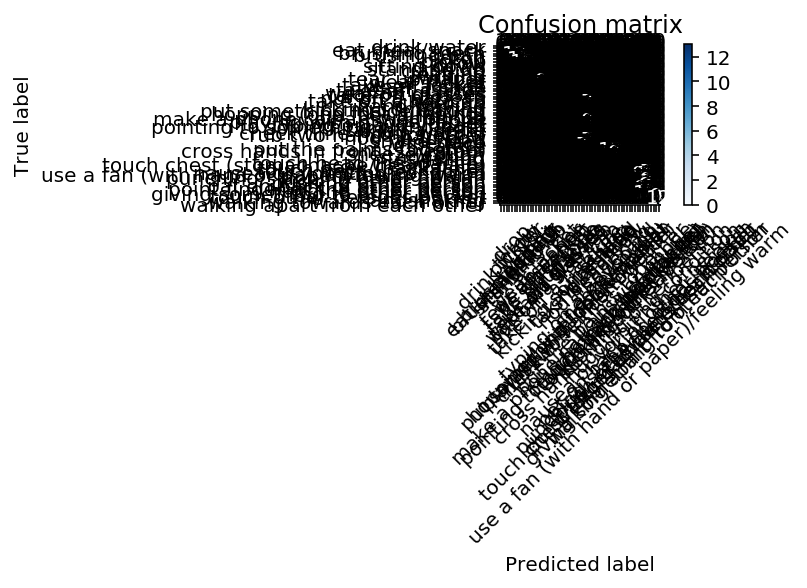

In [15]:
x = HDF5Matrix('E:/nturgbd_skeletons/dataset.h5', 'testdata', 5000, 6000)
vtarget = HDF5Matrix('E:/nturgbd_skeletons/dataset.h5', 'testlabel', 5000, 6000)


classes = ['drink water',
'eat meal/snack',
'brushing teeth',
'brushing hair',
'drop',
'pickup',
'throw',
'sitting down',
'standing up',
'clapping',
'reading',
'writing',
'tear up paper',
'wear jacket',
'take off jacket',
'wear a shoe',
'take off a shoe',
'wear on glasses',
'take off glasses',
'put on a hat/cap',
'take off a hat/cap',
'cheer up',
'hand waving',
'kicking something',
'put something inside pocket',
'hopping (one foot jumping)',
'jump up',
'make a phone call/answer phone',
'playing with phone/tablet',
'typing on a keyboard',
'pointing to something with finger',
'taking a selfie',
'check time (from watch)',
'rub two hands together',
'nod head/bow',
'shake head',
'wipe face',
'salute',
'put the palms together',
'cross hands in front (say stop)',
'sneeze/cough',
'staggering',
'falling',
'touch head (headache)',
'touch chest (stomachache/heart pain)',
'touch back (backache)',
'touch neck (neckache)',
'nausea or vomiting condition',
'use a fan (with hand or paper)/feeling warm',
'punching/slapping other person',
'kicking other person',
'pushing other person',
'pat on back of other person',
'point finger at the other person',
'hugging other person',
'giving something to other person',
'touch other persons pocket',
'handshaking',
'walking towards each other',
'walking apart from each other']

full_multiclass_report(model, x, vtarget, classes)